In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

import matplotlib.pyplot as plt

import os
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
import torchvision.transforms as transforms

from tqdm import tqdm

import time

import PIL

Mounted at /content/drive


In [2]:
!pip install torchinfo

In [3]:
import torchinfo

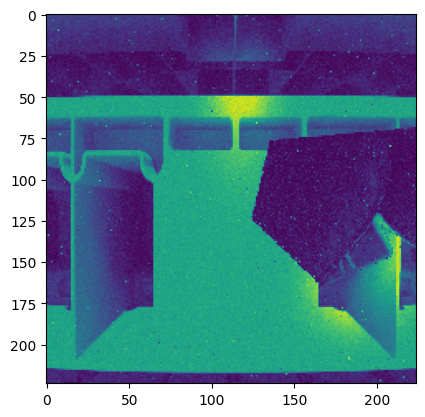

In [4]:
class CustomRGBImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[0:9000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class CustomDepthImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[0:9000]
        for index, img_label in enumerate(self.img_labels.iloc[:,0]):
            depth_img_label = img_label.replace("rgb_image_", "depth_image_").replace("png", "npy")
            self.img_labels.iloc[index,0] = depth_img_label

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        np_img = np.load(img_path)
        np_img[np_img > 1] = 0
        image = torch.tensor(np_img).unsqueeze(0)
        image = image.expand(3, *image.shape[1:])
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label





depth_transform  = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    #torchvision.transforms.ToTensor(),
])


#print(os.path.exists("drive/MyDrive/Colab Notebooks/dataset_20k/dataset/labels.csv"))

path_to_labels = "drive/MyDrive/Colab Notebooks/dataset_nd_rgb_resize-10k/dataset/labels.csv"
path_to_rgb_imgs = "drive/MyDrive/Colab Notebooks/dataset_nd_rgb_resize-10k/dataset/rgb/"
path_to_depth_imgs = "drive/MyDrive/Colab Notebooks/dataset_nd_rgb_resize-10k/dataset/depth/"


dataset_rgb = CustomRGBImageDataset(path_to_labels, path_to_rgb_imgs)
dataset_depth = CustomDepthImageDataset(path_to_labels, path_to_depth_imgs, transform = depth_transform)


#generator1 = torch.Generator().manual_seed(42)

#[rgb_training_data, rgb_test_data] = torch.utils.data.random_split(dataset_rgb, [0.9, 0.1], generator1)
#[depth_training_data, depth_test_data] = torch.utils.data.random_split(dataset_depth, [0.9, 0.1], generator1)



batch_size = 32



rgb_train_dataloader = DataLoader(dataset_rgb, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)
#rgb_test_dataloader = DataLoader(rgb_test_data, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)

depth_train_dataloader = DataLoader(dataset_depth, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)
#depth_test_dataloader = DataLoader(depth_test_data, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)


plt.imshow(dataset_rgb.__getitem__(8999)[0][2])

tensor(0.9992, dtype=torch.float64)


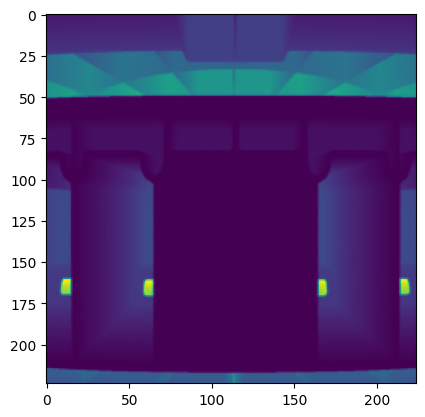

In [5]:
plt.imshow(dataset_depth.__getitem__(8999)[0][2])

print(torch.max(dataset_depth.__getitem__(4)[0]))

#plt.imshow(rgb_training_data.__getitem__(0)[0][0])
#plt.show()

In [6]:
rgb_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)
depth_cnn = resnet50(weights=ResNet50_Weights.DEFAULT)





Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.6MB/s]


In [7]:
# depth_cnn.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)

depth_cnn.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(2048,100,bias=True),
    nn.Tanh()
)

rgb_cnn.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(2048,100,bias=True),
    nn.Tanh()
)

final_pose_estimator = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(200, 6, bias=True)

)


depth_cnn.to('cuda')
rgb_cnn.to('cuda')
final_pose_estimator.to('cuda')

def paralle_cnn(rgb, depth):
    rgb_out = rgb_cnn(rgb)
    depth_out = rgb_cnn(depth)
    cat_out = torch.cat([rgb_out, depth_out], dim=1)
    return final_pose_estimator(cat_out)

torchinfo.summary(depth_cnn)


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [8]:
rgb_cnn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
rgb_cnn.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [12]:
lossFunc = nn.MSELoss()
optimizer = optim.Adam(list(depth_cnn.parameters()) + list(rgb_cnn.parameters()) + list(final_pose_estimator.parameters()), lr=0.001)



In [13]:
for epoch in range(1):
    inner_loop_counter = 0
    for [rgb_inputs, labels], [depth_inputs, labels_2] in zip(rgb_train_dataloader, depth_train_dataloader):
        print([torch.isnan(rgb_inputs).any(), torch.isnan(depth_inputs).any()])

        if not torch.isnan(depth_inputs).any().item():
            acc = None
            # forward, backward, and then weight update
            y_pred = paralle_cnn(rgb_inputs.float().cuda(), depth_inputs.float().cuda())
            #print(f"raw output {y_pred}")
            loss = lossFunc(y_pred, labels.float().cuda())

            print(f" test labels {torch.sum(labels - labels_2)}")
            print(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"training loop complete inner loop {inner_loop_counter}")
            inner_loop_counter += 1
        else:
            print('loop skiped due to bad input')
        #test_pred = model((test_input.float()).type(torch.cuda.FloatTensor))
        #acc += torch.mean(torch.abs(y_pred - labels.type(torch.cuda.FloatTensor)),dim = 0)
        #print(f"acc {acc}")
    print(f"epoch {epoch}")

[tensor(False), tensor(False)]
 test labels 0.0
0.005017857998609543
training loop complete inner loop 0
[tensor(False), tensor(False)]
 test labels 0.0
0.015599946491420269
training loop complete inner loop 1
[tensor(False), tensor(False)]
 test labels 0.0
0.0033470753114670515
training loop complete inner loop 2
[tensor(False), tensor(False)]
 test labels 0.0
0.0033789360895752907
training loop complete inner loop 3
[tensor(False), tensor(False)]
 test labels 0.0
0.0013177933869883418
training loop complete inner loop 4
[tensor(False), tensor(False)]
 test labels 0.0
0.0009652997250668705
training loop complete inner loop 5
[tensor(False), tensor(False)]
 test labels 0.0
0.000815811101347208
training loop complete inner loop 6
[tensor(False), tensor(False)]
 test labels 0.0
0.0008859417284838855
training loop complete inner loop 7
[tensor(False), tensor(False)]
 test labels 0.0
0.0007481206557713449
training loop complete inner loop 8
[tensor(False), tensor(False)]
 test labels 0.0
0

In [16]:
torch.save(rgb_cnn.state_dict(), "dual_resnet50pose_rgb.pth")
torch.save(depth_cnn.state_dict(), "dual_resnet50pose_depth.pth")
torch.save(final_pose_estimator.state_dict(), "dual_final_pose_estimator.pth")

In [17]:
from google.colab import files

files.download('dual_resnet50pose_rgb.pth')
files.download("dual_resnet50pose_depth.pth")
files.download("dual_final_pose_estimator.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
class CustomRGBImageTestDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[9000:10000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class CustomDepthImageTestDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[9000:10000]
        for index, img_label in enumerate(self.img_labels.iloc[:,0]):
            depth_img_label = img_label.replace("rgb_image_", "depth_image_").replace("png", "npy")
            self.img_labels.iloc[index,0] = depth_img_label

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        np_img = np.load(img_path)
        np_img[np_img > 1] = 0
        image = torch.tensor(np_img).unsqueeze(0)
        image = image.expand(3, *image.shape[1:])
        label = torch.tensor(self.img_labels.iloc[idx, 1:7])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


test_dataset_rgb = CustomRGBImageTestDataset(path_to_labels, path_to_rgb_imgs)
test_dataset_depth = CustomDepthImageTestDataset(path_to_labels, path_to_depth_imgs, transform = depth_transform)

rgb_test_dataloader = DataLoader(test_dataset_rgb, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)


depth_test_dataloader = DataLoader(test_dataset_depth, batch_size=batch_size ,shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=30)




In [22]:
acc = 0
count = 0
for [rgb_inputs, labels], [depth_inputs, labels_2] in zip(rgb_test_dataloader, depth_test_dataloader):
    with torch.no_grad():  # Ensure no gradients are calculated
        if not torch.isnan(depth_inputs).any().item():
            y_pred = paralle_cnn(rgb_inputs.float().cuda(), depth_inputs.float().cuda())
            acc += (y_pred - labels.type(torch.cuda.FloatTensor))
            count += 1
            print(labels.size())
            print(count)
            print(f"test {acc / count}")
        else:
            print('loop skiped due to bad input')

# Calculate final accuracy after all iterations
final_acc = acc / count

torch.Size([32, 6])
1
test tensor([[-3.5690e-03,  4.2402e-03,  7.4416e-03, -1.9452e-03, -2.8018e-03,
          1.7991e-04],
        [-8.3138e-03,  1.1651e-05,  4.7484e-03,  9.3052e-05, -5.3335e-03,
         -1.4435e-03],
        [-3.9023e-03, -7.3790e-03, -1.0849e-02, -5.2958e-04, -4.0302e-03,
          8.8226e-05],
        [ 8.6665e-03, -2.3927e-03, -4.1100e-03, -8.9469e-04, -5.4644e-03,
          2.2349e-03],
        [-4.6293e-03, -1.0322e-02,  5.0770e-03,  3.6190e-03, -4.9738e-03,
          3.0930e-03],
        [ 2.6622e-03, -1.9874e-03,  1.6040e-03,  3.9140e-03, -4.0033e-03,
          2.1285e-03],
        [ 1.5128e-03,  2.8948e-03,  4.1575e-03, -3.9184e-04, -2.7342e-03,
          7.0008e-04],
        [-8.8541e-03,  6.0640e-03,  5.1521e-04,  9.0224e-04, -5.6965e-04,
          2.0139e-03],
        [-1.0848e-02,  1.3784e-02, -1.1320e-03,  1.3236e-03,  6.7883e-04,
          1.3849e-03],
        [-2.5824e-02,  2.1265e-02,  4.5395e-03, -4.0388e-03,  2.5403e-03,
          1.4915e-03],
   

KeyboardInterrupt: 